Squeezenet于2016年提出，开始将注意力放在模型计算量与参数量上，用网络结构设计来减少参数量（另一种思路是模型剪枝）。Squeezenet取得的效果是达到说Alexnet相近的精度，但参数量是Alexnet的50分之一，结合模型压缩，可将模型压缩至0.5MB，是Alexnet的510
分之一。


现在的模型大多关注精度，但忽略了计算量与实时性。一个小的模型有三个优点：<br/>
1）	分布式训练时应该有更少的通信量。<br/>
2）	应用在自动驾驶设备上时，与云端的通信应该要求更少的带宽。<br/>
3）	更适合部署在FPGAs与其它内存低的硬件设备上。<br/>
基于此，我们设计了squeezenet，在保持精度的基础上减少参数量。

模型设计策略：我们的目标是在保持精度的基础上减少参数量，为此，我们提出了3个主要的策略：<br/>
1）	用1x1卷积代替3x3卷积。3x3卷积参数量是1x1卷积的9倍。<br/>
2）	减少3x3卷积输入张量的维度。用squeeze layers来实现这个目的。<br/>
3）	将下采样操作滞后。特征图尺寸受三个因素影响：输入尺寸、在哪一层执行下采样。一般来说，下采样由stride>1的pooling或conv层完成。我们认为将下采样滞后可以增大输入到卷积层的特征图尺寸，从而提升分类精度。

Fire module:一个fire module由一个squeeze 卷积层与一个expand层组成，其中squeeze层只包含1x1卷积,expand层包含1x1与3x3卷积，如下图所示。$Fire module有3个超参数：s_{1x1}，e_{1x1}, e_{3x3}.s_{1x1}是squeeze层中filter数量,\\e_{1x1}是expand层1x1卷积核数量，e_{3x3}是expand层3x3卷积数量.在设计时，\\设置如下：s_{1x1} < (e_{1x1} + e_{3x3})。$
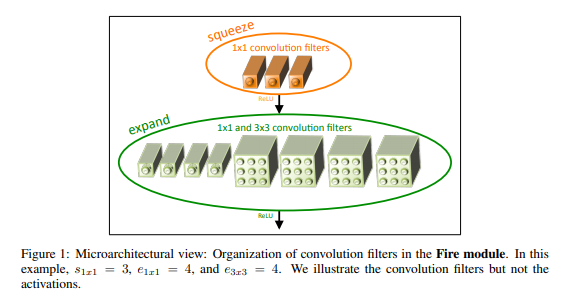

Squeezenet网络结构：网络结构如下图所示。从开始到结束缓慢增加filter数量，将pooing滞后。整个squeezenet网络结构下表所示。
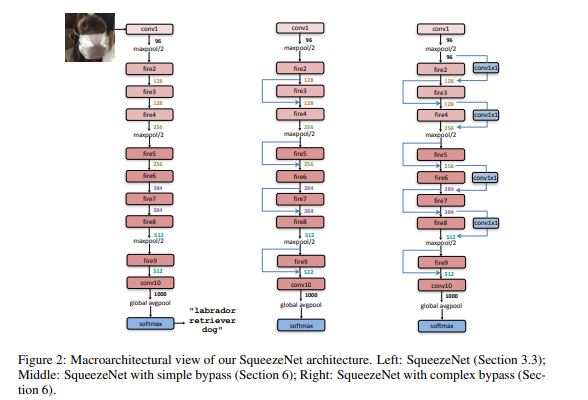

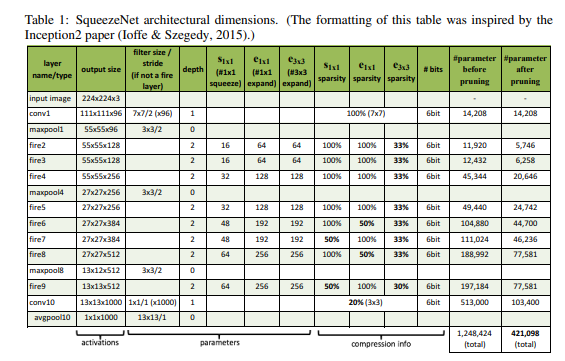

其他设计细节：<br/>
1）	fire module中，3x3卷积的输入有一个像素的zero-padding。<br/>
2）	应用ReLU。<br/>
3）	Dropout。<br/>
4）	仿照NIN，去掉全连接层。

CNN网络设计探索：找到网络设计的直觉（intuition）<br/>
$CNN microarchitecture metaparameters（元参数）: fire module有三个超参数，\\那么squeezenet有8个fire module,就有24个超参数。为了简化设计，我们用元参数来代替。\\定义basee为第一个filre模块中expand层的filter数量,在之后的每个fire模块，用incre_e与freq(增加频率，每隔几个fire module增加一次filter数量)来增加数量，即第i个fire module模块\\中，expand层的filter数量是ei = base_e + (incre_e * floor(i / freq))。在expand层，\\定义pct_{3x3}为expand层中3x3卷积的比例，pct_{3x3}在[0,1]范围内。定义squeeze ratio(SR)\\为squeeze层的卷积核数量（s_{I, 1x1} = SR * (e_{i, 1x1} + e_{I, 3x3})）。Squeezenet就是基于这些\\元参数组成的，如表1所示，\\其元参数设置为：base_e=128，incre_e=128, pct_{3x3} = 0.5，freq = 2, SR=0.125.$

SR：通过实验发现，SR大于0.125时，随着SR增大，Accuracy提升，同时参数量也有略微增加，知道SR达到0.75，Accuracy达到最大值。<br/>
Trade off 1x1 and 3x3 conv: 通过实验发现，pct_{3x3}设为0.5时，即有一半3x3卷积核时，模型性能最好。

CNN Macroarchitecture design:仿照resnet，我们设计了三种不同的结构：<br/>
1）	普通的squeezenet.<br/>
2）	包含简单shortcut层的squeezenet。<br/>
3）	包含复杂shortcut层的squeezenet。<br/>
如图2所示。<br/>
直觉上，添加shortcut层可以帮助缓解bottleneck带来的影响，为流经squeeze层的信息添加了一个快车道。 实验也表明，添加shortcut层的squeezenet（简单与复杂shorcut）能够取得比普通squeezenet 的精度。此外，比较意外的是，简单shortcut比复杂shortcut准确度更高。